In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, classification_report
from scipy.signal import resample
import random
np.random.seed(42)

import torch
import torch.nn as nn
from torch.optim import Adam
import seaborn as sns

torch.manual_seed(42)
torch.backends.cudnn.benchmark = False

In [ ]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'axes.grid':True,
         'axes.grid.which':'both'
         }
plt.rcParams.update(params)

# Read Dataset

In [ ]:
df = pd.read_csv("./drive/MyDrive/mitbih_train.csv", header=None)
df2 = pd.read_csv("./drive/MyDrive/mitbih_test.csv", header=None)
# df = pd.concat([df, df2], axis=0)
df = df.reset_index().drop('index', axis='columns')

It is a good idea to look at the distribution of the data before working with it.

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
0,87554.0,0.890360,0.240909,0.0,0.921922,0.991342,1.000000,1.0
1,87554.0,0.758160,0.221813,0.0,0.682486,0.826013,0.910506,1.0
2,87554.0,0.423972,0.227305,0.0,0.250969,0.429472,0.578767,1.0
3,87554.0,0.219104,0.206878,0.0,0.048458,0.166000,0.341727,1.0
4,87554.0,0.201127,0.177058,0.0,0.082329,0.147878,0.258993,1.0
...,...,...,...,...,...,...,...,...
183,87554.0,0.003471,0.036255,0.0,0.000000,0.000000,0.000000,1.0
184,87554.0,0.003221,0.034789,0.0,0.000000,0.000000,0.000000,1.0
185,87554.0,0.002945,0.032865,0.0,0.000000,0.000000,0.000000,1.0
186,87554.0,0.002807,0.031924,0.0,0.000000,0.000000,0.000000,1.0


- All the fields are between  0 and 1.
- The last fields are mostly zeros.
- count is always the same number. We deduce that there are no missing values.
- The last row has a maximum of 4.... A look at the paper tells us that this is the target field. It is categorical with 4 categories:


In [ ]:
label_names = {0 : 'N',
              1: 'S',
              2: 'V',
              3: 'F',
              4 : 'Q'}

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87554 entries, 0 to 87553
Columns: 188 entries, 0 to 187
dtypes: float64(188)
memory usage: 125.6 MB


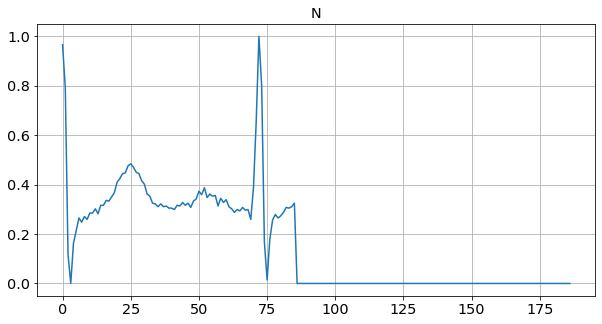

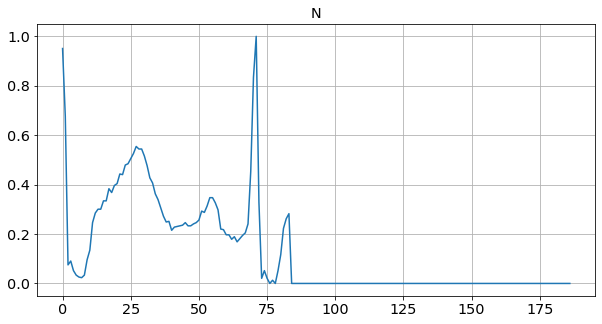

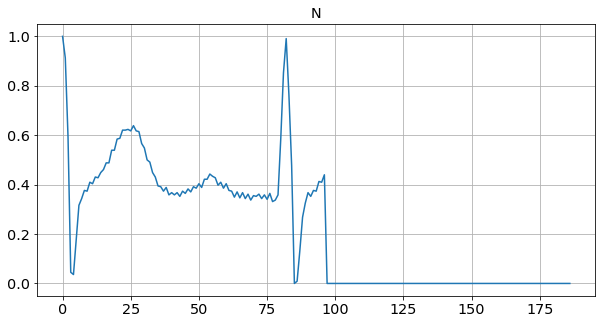

In [ ]:
# show some data
for _ in range(3):
    plt.figure()
    sample = df.sample(1).values.flatten()
    y = label_names[sample[-1]]
    plt.plot(sample[:-1])
    t = plt.title(y)

## Distribution of labels

In [ ]:
label=df[187].value_counts()
label

0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: 187, dtype: int64

<AxesSubplot:>

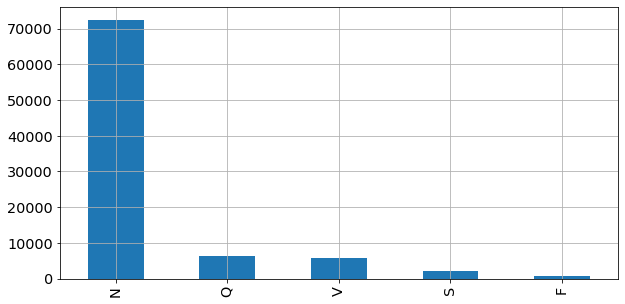

In [ ]:
label.rename(label_names).plot.bar()

In [ ]:
label=df2[187].value_counts()
label

0.0    18118
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: 187, dtype: int64

<AxesSubplot:>

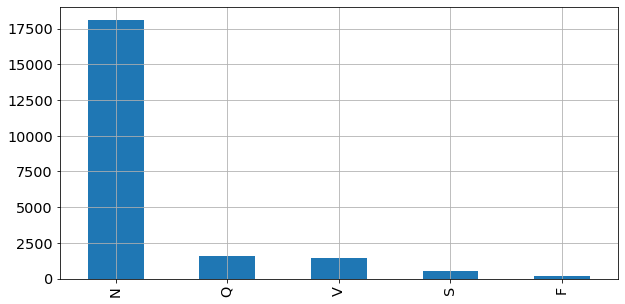

In [ ]:
label.rename(label_names).plot.bar()

In [ ]:
def stretch(x):
    l = int(187 * (1 + (random.random()-0.5)/3))
    y = resample(x, l)
    if l < 187:
        y_ = np.zeros(shape=(187, ))
        y_[:l] = y
    else:
        y_ = y[:187]
    return y_

def amplify(x):
    alpha = (random.random()-0.5)
    factor = -alpha*x + (1+alpha)
    return x*factor


class Stretch:
    def __init__(self):
        pass
    
    def __call__(self,x):
        return stretch(x)
    
    def __repr__(self):
        return 'Stretch'
    
class Amplify:
    def __init__(self):
        pass
    
    def __call__(self,x):
        return amplify(x)
    
    def __repr__(self):
        return 'Amplify'

class Augment:
    def __init__(self, augmentation_list, return_prints = False):
        self.augmentation_list = augmentation_list
        self.return_prints = return_prints
        
    def __call__(self, x):
        augmentations_performed = ''
        
        for augmentation in self.augmentation_list:
            if np.random.binomial(1, 0.5) == 1:
                x = augmentation(x)
                augmentations_performed += f'{augmentation} '
                
        if not self.return_prints:
            return x
        return x, augmentations_performed



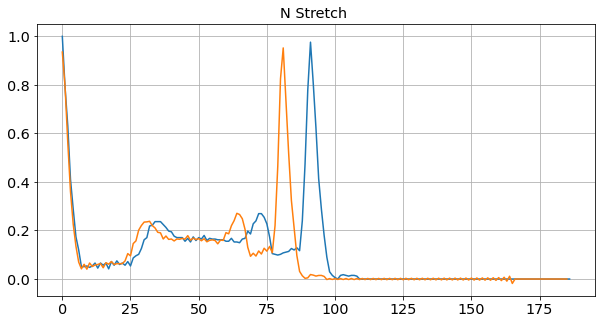

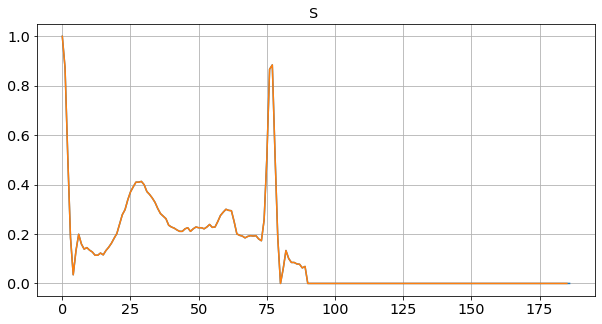

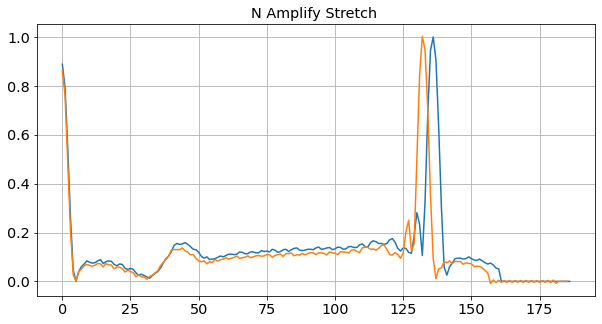

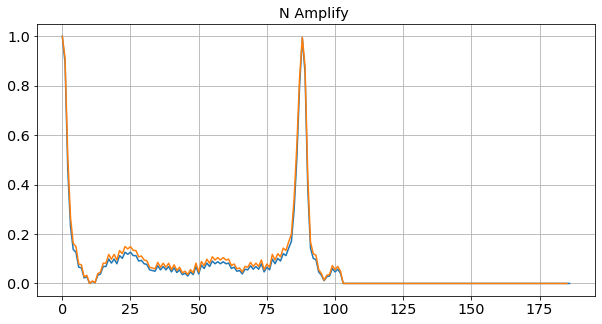

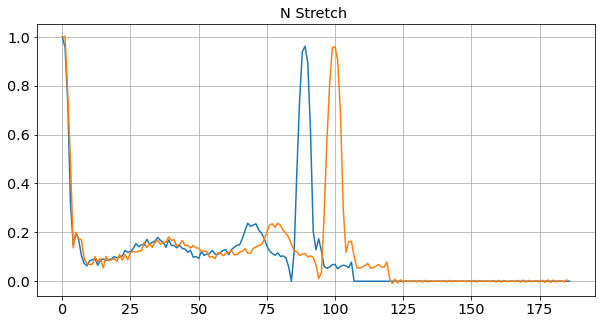

In [ ]:
augment = Augment([Amplify(), Stretch()], True)
for _ in range(5):
    plt.figure()
    sample = df.sample(1).values.flatten()
    y = label_names[sample[-1]]
    plt.plot(sample[:-1])
    
    augmented, augmentations_performed = augment(sample[:-1])
    plt.plot(augmented[:-1])
    
    title = plt.title(y + ' ' + augmentations_performed)

# Split Dataset

In [ ]:
from sklearn.model_selection import train_test_split

# train_df, test_val_df = train_test_split(df, train_size=0.9, stratify=df.iloc[:,-1])
# val_df, test_df = train_test_split(test_val_df, test_size=0.5, stratify=test_val_df.iloc[:,-1])

train_df, val_df = train_test_split(df, train_size=0.8, stratify=df.iloc[:,-1])
test_df = df2
# Make sure the target distribution stays the same...
for temp_df in [train_df, val_df, test_df]:
    print(temp_df.shape[0], temp_df.shape[0] / df.shape[0])
    print(temp_df.iloc[:,-1].value_counts(normalize=True))
    print('\n')

70043 0.7999977156954565
0.0    0.827734
4.0    0.073455
2.0    0.066102
1.0    0.025384
3.0    0.007324
Name: 187, dtype: float64


17511 0.20000228430454348
0.0    0.827708
4.0    0.073440
2.0    0.066130
1.0    0.025413
3.0    0.007310
Name: 187, dtype: float64


21892 0.25003997532951094
0.0    0.827608
4.0    0.073451
2.0    0.066143
1.0    0.025397
3.0    0.007400
Name: 187, dtype: float64




Note the probabilities! 

### Undersample the over-represented
There is a huge imbalance. The model can easily diminish the loss by ignoring everything other than class 0.
There are several ways to handle this - oversample, undersample, bootstrapping etc.
First, we look at the distribution of samples in the training set:

187
0.0    57977
1.0     1778
2.0     4630
3.0      513
4.0     5145
dtype: int64

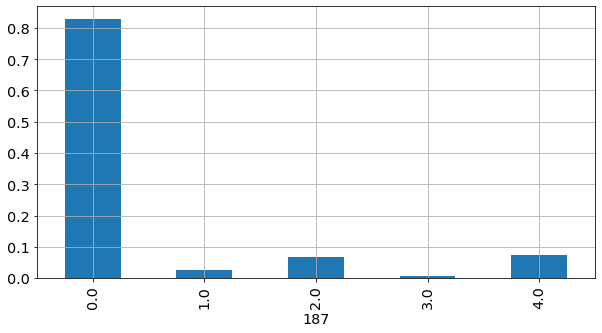

In [ ]:
col = train_df.groupby(187).size()
(col / col.sum()).plot.bar()
col

Next we take the over represented class (N) and sample 5000 samples, randomly. These will be used for training and the rest are ignored.

C:\Users\dltmd\AppData\Local\Temp\ipykernel_14776\623412903.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  train_df = non_normal_rows.append(normal_rows)


187
0.0    5000
1.0    1778
2.0    4630
3.0     513
4.0    5145
dtype: int64

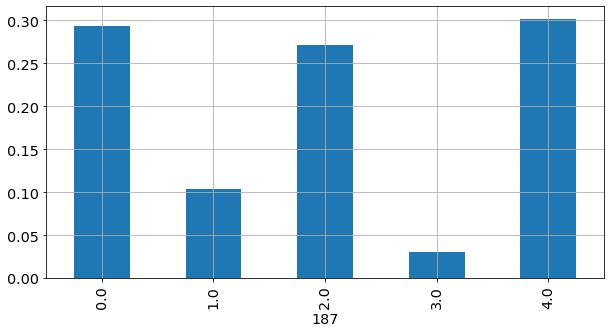

In [ ]:
non_normal_rows = train_df.loc[train_df.iloc[:,-1] != 0]
normal_rows = train_df.loc[train_df.iloc[:,-1] == 0].sample(5000)

train_df = non_normal_rows.append(normal_rows)

col = train_df.groupby(187).size()
(col / col.sum()).plot.bar()
col


![image.png](attachment:image.png)

In [ ]:
class A(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.intro_bn = nn.BatchNorm1d(32)
    
        self.C11 = nn.Conv1d(32, 32, kernel_size=5, padding=2)
        self.A11 = nn.ReLU()
        self.C12 = nn.Conv1d(32, 32, kernel_size=5, padding=2)
        self.A12 = nn.ReLU()
        self.M11 = nn.MaxPool1d(kernel_size=5, stride=2)

    def forward(self, x):
        x = self.intro_bn(x)
        C = x
        x = self.C11(x)
        x = self.A11(x)
        x = self.C12(x)
        x = x + C
        x = self.A12(x)
        x = self.M11(x)
        
        return x
    
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv_in = nn.Conv1d(1, 32, kernel_size=5)
        
        self.A_blocks = nn.ModuleList(A() for i in range(5))
        
        self.avg_pool = nn.AvgPool1d(2)
        self.fc1 = nn.Linear(32,32)
        self.acc1 = nn.ReLU()
        self.fc2 = nn.Linear(32,5)
        
    def forward(self, x):
        x = self.conv_in(x)
        
        for i in range(5):
            x = self.A_blocks[i](x)
        
        x = self.avg_pool(x)
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = self.acc1(x)
        x = self.fc2(x)
        
        return x
    

In [ ]:
batch_size = 256
epochs = 10 # 75
lr = 1e-3
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
n_splits = 7

In [ ]:
from torch.utils.data import Dataset, DataLoader

class ds(Dataset):
  def __init__(self, x, y=None, transforms=None):
    super().__init__()

    self.X = x
    self.Y = y
    self.transforms = transforms

  def __len__(self):
    return self.X.shape[0]

  def __getitem__(self,idx):
    x = self.X.iloc[idx,:]
    
    if self.transforms is not None:
        x = self.transforms(x)

    if self.Y is not None:
      return torch.Tensor(x).view(1,-1).float(), torch.Tensor([self.Y.iloc[idx]]).float().squeeze()

    return torch.Tensor(x).float()

augment = Augment([Amplify(), Stretch()])

train_set = ds(train_df.iloc[:,:-1], train_df.iloc[:,-1], transforms=augment)
val_set = ds(val_df.iloc[:,:-1], val_df.iloc[:,-1])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size*4)

Note we take special care to not accidently send the label to the model (column -1).

## Train Model

In [ ]:
# model = Model().to(device)

criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=lr)

from torch.optim.lr_scheduler import ReduceLROnPlateau
# lr_sched = ReduceLROnPlateau(optimizer, patience=3) # None for a manual LR regimen

ADAM optimizer


In [ ]:
epoch_train_losses = []
epoch_val_losses = []

from sklearn.model_selection import KFold
kf = KFold(n_splits=n_splits)
for fold_n, (train_idx, val_idx) in enumerate(kf.split(df)):
    train_set = ds(df.iloc[train_idx,:-1], df.iloc[train_idx,-1], transforms=augment)
    val_set = ds(df.iloc[val_idx,:-1], df.iloc[val_idx,-1])

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size*4)
    
    model = Model().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    lr_sched = ReduceLROnPlateau(optimizer, patience=3)
    for epoch in range(epochs):
        epoch_train_loss = 0
        epoch_val_loss = 0

        model.train()
        for batch_id, (x,y_true) in enumerate(train_loader):
            y_pred = model(x.to(device))

            optimizer.zero_grad()
            loss = criterion(y_pred, y_true.long().to(device))
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item() / len(train_loader)

        model.eval()
        with torch.no_grad():
            for batch_id, (x,y_true) in enumerate(val_loader):
                y_pred = model(x.to(device))
                loss = criterion(y_pred, y_true.long().to(device))

                epoch_val_loss += loss.item() / len(val_loader)


        epoch_train_losses.append(epoch_train_loss)
        epoch_val_losses.append(epoch_val_loss)
        print(f'Fold {fold_n} Epoch {epoch}:\tTrain loss: {epoch_train_loss:0.2e}\tVal loss: {epoch_val_loss:0.2e} \tLR: {optimizer.param_groups[0]["lr"]:0.2e}')

        if lr_sched is None:
            if epoch % 10 == 0 and epoch > 0:
                optimizer.param_groups[0]['lr'] /= 10
                print(f'Reducing LR to {optimizer.param_groups[0]["lr"]}')
        else:
            lr_sched.step(epoch_val_loss)
    torch.save(model.state_dict(), f'model_fold_{fold_n}.pth')


Fold 0 Epoch 0:	Train loss: 2.66e-01	Val loss: 4.96e-02 	LR: 1.00e-03
Fold 0 Epoch 1:	Train loss: 1.16e-01	Val loss: 2.02e-02 	LR: 1.00e-03
Fold 0 Epoch 2:	Train loss: 9.20e-02	Val loss: 2.15e-02 	LR: 1.00e-03
Fold 0 Epoch 3:	Train loss: 8.15e-02	Val loss: 4.04e-02 	LR: 1.00e-03
Fold 0 Epoch 4:	Train loss: 7.17e-02	Val loss: 3.00e-02 	LR: 1.00e-03
Fold 0 Epoch 5:	Train loss: 6.56e-02	Val loss: 2.06e-02 	LR: 1.00e-03
Fold 0 Epoch 6:	Train loss: 5.03e-02	Val loss: 1.76e-02 	LR: 1.00e-04
Fold 0 Epoch 7:	Train loss: 4.51e-02	Val loss: 1.82e-02 	LR: 1.00e-04
Fold 0 Epoch 8:	Train loss: 4.48e-02	Val loss: 1.84e-02 	LR: 1.00e-04
Fold 0 Epoch 9:	Train loss: 4.34e-02	Val loss: 1.52e-02 	LR: 1.00e-04
Fold 1 Epoch 0:	Train loss: 2.54e-01	Val loss: 2.86e-02 	LR: 1.00e-03
Fold 1 Epoch 1:	Train loss: 1.22e-01	Val loss: 4.22e-02 	LR: 1.00e-03
Fold 1 Epoch 2:	Train loss: 9.36e-02	Val loss: 5.77e-03 	LR: 1.00e-03
Fold 1 Epoch 3:	Train loss: 7.90e-02	Val loss: 1.27e-02 	LR: 1.00e-03
Fold 1 Epoch 4:	Trai

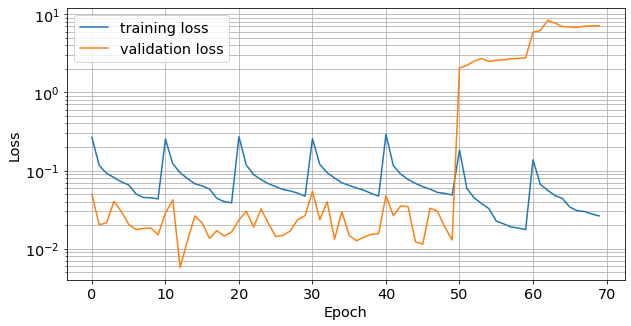

In [ ]:
plt.plot(np.arange(len(epoch_train_losses)), epoch_train_losses)
plt.plot(np.arange(len(epoch_val_losses)), epoch_val_losses)
plt.legend(['training loss','validation loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')

## Test the model - Validation set

In [ ]:
predictions = []
labels = []

model.eval()
with torch.no_grad():
    for batch_id, (x,y_true) in enumerate(val_loader):
        y_pred = model(x.to(device)).argmax(1)
        
        predictions.extend(y_pred.squeeze().tolist())
        labels.extend(y_true.squeeze().tolist())
        
prediction_labels = pd.DataFrame(np.array([predictions, labels]).T, columns=['Prediction', 'Label'])
cm = prediction_labels.groupby(['Prediction', 'Label']).size()
cm.unstack(0)

Prediction,0.0,1.0,2.0
Label,,,
2.0,912,204,4319
3.0,516,2,123
4.0,4634,178,1619


In [ ]:
print(classification_report(predictions, labels))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      6062
         1.0       0.00      0.00      0.00       384
         2.0       0.79      0.71      0.75      6061
         3.0       0.00      0.00      0.00         0
         4.0       0.00      0.00      0.00         0

    accuracy                           0.35     12507
   macro avg       0.16      0.14      0.15     12507
weighted avg       0.39      0.35      0.36     12507



C:\Users\dltmd\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dltmd\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dltmd\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\dltmd\anaconda3\lib\site-packages\sklearn\metrics\_cla

## Test the model - Test set

In [ ]:
test_set = ds(test_df.iloc[:,:-1], test_df.iloc[:,-1])
test_loader = DataLoader(test_set, batch_size=batch_size*4, shuffle=False)

predictions = []

model.eval()
with torch.no_grad():
    for fold in range(n_splits):
        model = Model().to(device)
        model.load_state_dict(torch.load(f'model_fold_{fold}.pth'))
        model.eval()
        
        fold_predictions = []
        labels = []
        for batch_id, (x,y_true) in enumerate(test_loader):
            y_pred = model(x.to(device)).argmax(1)

            fold_predictions.extend(y_pred.squeeze().tolist())
            labels.extend(y_true.squeeze().tolist())
        predictions.append(fold_predictions)
    
predictions.append(labels)
all_prediction_labels = pd.DataFrame(
    np.array(predictions).T, 
    columns=[f'fold {n}' for n in range(n_splits)] + ['Label']
#     columns=['fold 0', 'fold 1', 'fold 2','fold 3','fold 4', 'Label'],
#     columns=['fold 0', 'fold 1', 'fold 3', 'Label']
)

final_predictions = all_prediction_labels.iloc[:,:-1].mode(1).iloc[:,0]
prediction_labels = pd.DataFrame(
    np.hstack([
        final_predictions.values.reshape(-1,1), 
        all_prediction_labels.loc[:,'Label'].values.reshape(-1,1)]
    ),
    columns=['Prediction', 'Label']
)
prediction_labels

cm = prediction_labels.groupby(['Prediction', 'Label']).size()
cm.unstack(0)

Prediction,0.0,1.0,2.0,3.0,4.0
Label,,,,,
0.0,18087.0,22.0,8.0,1.0,NaN
1.0,113.0,432.0,11.0,NaN,NaN
2.0,36.0,3.0,1394.0,13.0,2.0
3.0,23.0,NaN,14.0,125.0,NaN
4.0,15.0,NaN,NaN,NaN,1593.0


In [ ]:
predictions = prediction_labels.loc[:,'Prediction'].values
labels = prediction_labels.loc[:,'Label'].values
print(classification_report(predictions, labels))

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     18274
         1.0       0.78      0.95      0.85       457
         2.0       0.96      0.98      0.97      1427
         3.0       0.77      0.90      0.83       139
         4.0       0.99      1.00      0.99      1595

    accuracy                           0.99     21892
   macro avg       0.90      0.96      0.93     21892
weighted avg       0.99      0.99      0.99     21892



In [ ]:
report = pd.DataFrame(classification_report(predictions, labels,output_dict = 1)).T

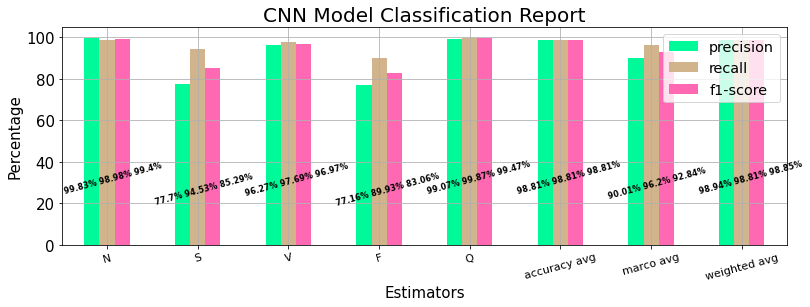

In [ ]:
colors = ['#00FA9A', '#D2B48C', '#FF69B4']#random.choices(list(mcolors.CSS4_COLORS.values()), k = 3)
report_plot = report.apply(lambda x: x*100)
ax = report_plot[["precision", "recall", "f1-score"]].plot(kind='bar',
                                                      figsize=(13, 4), legend=True, fontsize=15, color=colors)

ax.set_xlabel("Estimators", fontsize=15)
ax.set_xticklabels(
    list(label_names.values())+["accuracy avg", "marco avg", "weighted avg"],
    rotation=15, fontsize=11)
ax.set_ylabel("Percentage", fontsize=15)
plt.title("CNN Model Classification Report", fontsize=20)

for percentage, p in zip(
    report[['precision', 'recall', 'f1-score']].values,
    ax.patches):
    
    percentage = " ".join([str(round(i*100, 2))+"%" for i in percentage])
    x = p.get_x() + p.get_width() - 0.4
    y = p.get_y() + p.get_height() / 4
    ax.annotate(percentage, (x, y), fontsize=8, rotation=15, fontweight='bold')
plt.show()

Text(0.5, 1.0, 'CNN Classification Report')

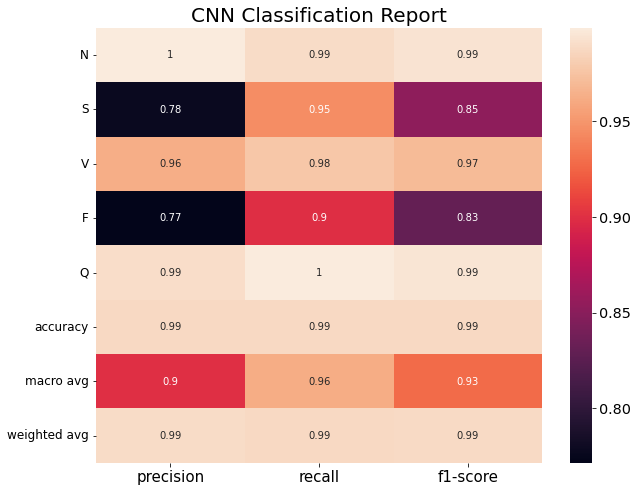

In [ ]:
clf_report = classification_report(predictions, labels, labels=[0,1,2,3,4], 
                                   target_names=list(label_names.values()),#['N', 'S', 'V', 'F', 'Q'],
                                   output_dict=True)
plt.figure(figsize=(10, 8))
ax = sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
ax.set_xticklabels(ax.get_xticklabels(),fontsize=15)
ax.set_yticklabels(ax.get_yticklabels(),fontsize=12, rotation=0)
plt.title("CNN Classification Report", fontsize=20)

In [ ]:
torch.save(model,'./cnn_model.pth')

In [ ]:
saved_model = torch.load('./cnn_model.pth')

# implement

In [ ]:
ecg = pd.read_csv('./drive/MyDrive/ecg_data.csv',header = None)
ecg[0] = ecg[0]/ecg[0].max()

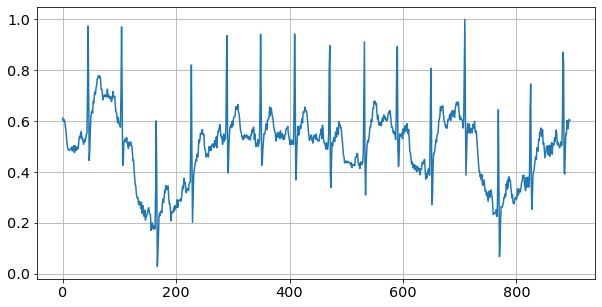

In [ ]:
plt.plot(ecg)

In [ ]:
ecg.head()

,0
0,0.611544
1,0.600624
2,0.600624
3,0.605304
4,0.597504


In [ ]:
ecg.shape

(895, 1)

In [ ]:
ecg = ecg[0:186]

In [ ]:
ecg = ecg.T

In [ ]:
ecg

,0,1,2,3,4,5,6,7,8,9,...,176,177,178,179,180,181,182,183,184,185
0,0.611544,0.600624,0.600624,0.605304,0.597504,0.575663,0.561622,0.533541,0.51014,0.49454,...,0.280811,0.293292,0.279251,0.297972,0.327613,0.318253,0.346334,0.341654,0.330733,0.338534


In [ ]:
ecg.shape

(1, 186)

In [ ]:
ecg_set = ds(ecg)
ecg_loader = DataLoader(ecg_set)

In [ ]:
dataiter= iter(ecg_loader)
x = dataiter.next()

In [ ]:
x.shape

torch.Size([1, 186])

In [ ]:
with torch.no_grad():
    ecgmodel = Model().to('cuda:0')
    ecgmodel.load_state_dict(torch.load('./drive/MyDrive/model_fold_6.pth',map_location =  'cuda:0'))
    ecgmodel.eval()

In [ ]:
with torch.no_grad():
  x = x.to('cuda:0')
  pred = ecgmodel(x)

  if not probs:
    pred = torch.argmax(pred,dim=1)

RuntimeError: ignored

In [ ]:
from torchsummary import summary as summary_
summary_(ecgmodel, (1,186),batch_size = batch_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [256, 32, 182]             192
       BatchNorm1d-2             [256, 32, 182]              64
            Conv1d-3             [256, 32, 182]           5,152
              ReLU-4             [256, 32, 182]               0
            Conv1d-5             [256, 32, 182]           5,152
              ReLU-6             [256, 32, 182]               0
         MaxPool1d-7              [256, 32, 89]               0
                 A-8              [256, 32, 89]               0
       BatchNorm1d-9              [256, 32, 89]              64
           Conv1d-10              [256, 32, 89]           5,152
             ReLU-11              [256, 32, 89]               0
           Conv1d-12              [256, 32, 89]           5,152
             ReLU-13              [256, 32, 89]               0
        MaxPool1d-14              [256,

In [ ]:
y_pred = ecgmodel(x.to('cuda:0')).argmax(1)

RuntimeError: ignored